#### Based on https://github.com/bkj/basenet/tree/master/examples

In [0]:
import sys
import json
import argparse
import numpy as np
from time import time
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

cifar10_stats = {
    "mean" : (0.4914, 0.4822, 0.4465),
    "std"  : (0.24705882352941178, 0.24352941176470588, 0.2615686274509804),
}

transform_train = transforms.Compose([
    transforms.Lambda(lambda x: np.asarray(x)),
    transforms.Lambda(lambda x: np.pad(x, [(4, 4), (4, 4), (0, 0)], mode='reflect')),
    transforms.Lambda(lambda x: Image.fromarray(x)),
    transforms.RandomCrop(32),
    
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_stats['mean'], cifar10_stats['std']),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_stats['mean'], cifar10_stats['std']),
])

train_loader = torch.utils.data.DataLoader(
                  datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train),
               batch_size=128, shuffle=True, pin_memory=True)

test_loader  = torch.utils.data.DataLoader(
                  datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test),
               batch_size=128, shuffle=True, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class PreActBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PreActBlock, self).__init__()
        
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        return out + shortcut

class ResNet18(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2], num_classes=10):
        super(ResNet18, self).__init__()
        
        self.in_channels = 64
        
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, num_blocks[0], stride=1),
            self._make_layer(64, 128, num_blocks[1], stride=2),
            self._make_layer(128, 256, num_blocks[2], stride=2),
            self._make_layer(256, 256, num_blocks[3], stride=2),
        )
        
        self.classifier = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(PreActBlock(in_channels=in_channels, out_channels=out_channels, stride=stride))
            in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.prep(x)
        x = self.layers(x)
        
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = x_avg.view(x_avg.size(0), -1)
        
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x_max = x_max.view(x_max.size(0), -1)
        
        x = torch.cat([x_avg, x_max], dim=-1)
        
        x = self.classifier(x)
        
        return x

In [0]:
model = ResNet18().to(device)

In [5]:
param_size = 0
for p in model.parameters():
    param_size += p.nelement()
param_size

5205962

In [6]:
_, (X, y) = next(enumerate(train_loader))
X.size(), y.size()

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

epoch 0/50, 0s since start
tensor(2.4228, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3262, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3261, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.6306 test_accuracy 0.6358


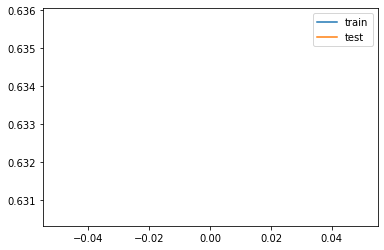

epoch 1/50, 58s since start
tensor(0.9612, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2283, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.7117 test_accuracy 0.7128


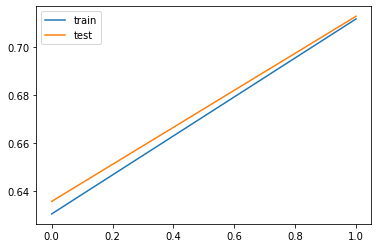

epoch 2/50, 115s since start
tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8265, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.7589 test_accuracy 0.7719


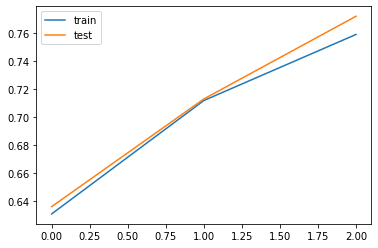

epoch 3/50, 172s since start
tensor(0.6093, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7024, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6228, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.7958 test_accuracy 0.8132


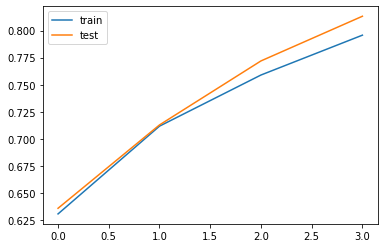

epoch 4/50, 230s since start
tensor(0.3913, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4074, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8259 test_accuracy 0.8173


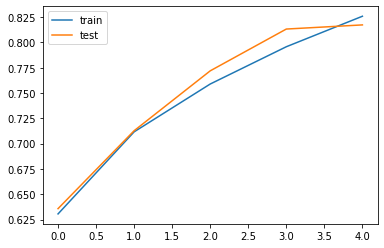

epoch 5/50, 287s since start
tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8423 test_accuracy 0.8356


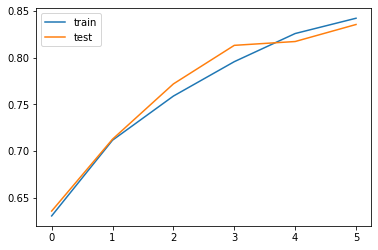

epoch 6/50, 345s since start
tensor(0.3187, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3858, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5942, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8475 test_accuracy 0.8344


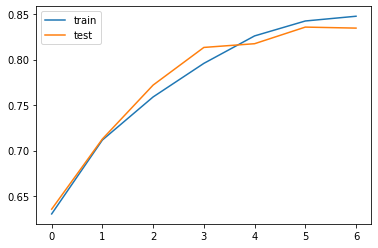

epoch 7/50, 402s since start
tensor(0.3684, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3434, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3892, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8664 test_accuracy 0.8486


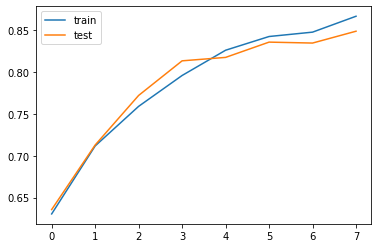

epoch 8/50, 459s since start
tensor(0.4100, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3777, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3068, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8806 test_accuracy 0.8624


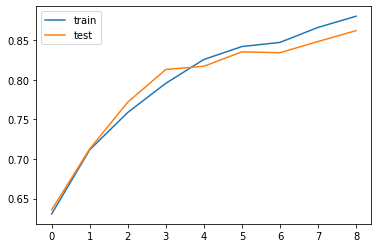

epoch 9/50, 517s since start
tensor(0.3524, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2613, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3083, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8951 test_accuracy 0.8638


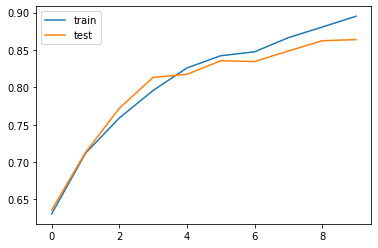

epoch 10/50, 574s since start
tensor(0.2229, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3190, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.8981 test_accuracy 0.8731


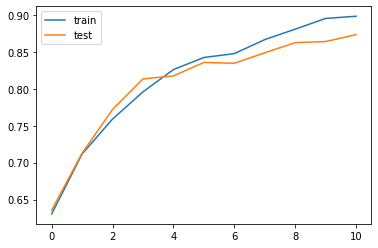

epoch 11/50, 631s since start
tensor(0.2532, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2576, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9167 test_accuracy 0.8865


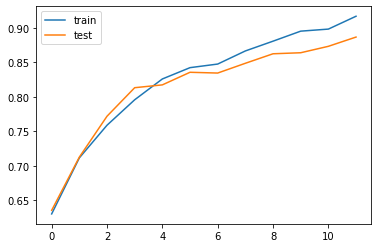

epoch 12/50, 689s since start
tensor(0.2773, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2687, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2040, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9137 test_accuracy 0.8876


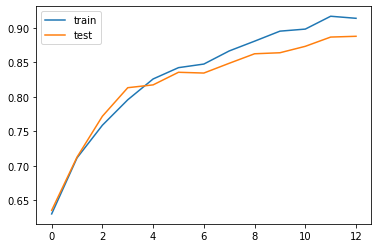

epoch 13/50, 746s since start
tensor(0.1678, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3250, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2618, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9230 test_accuracy 0.8865


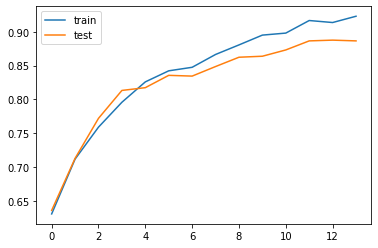

epoch 14/50, 803s since start
tensor(0.2030, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3455, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2194, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9249 test_accuracy 0.8955


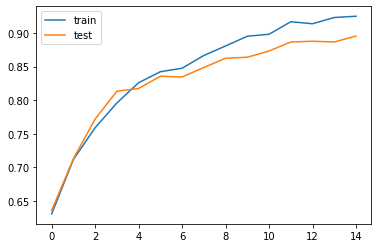

epoch 15/50, 860s since start
tensor(0.1560, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2464, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1999, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9260 test_accuracy 0.8943


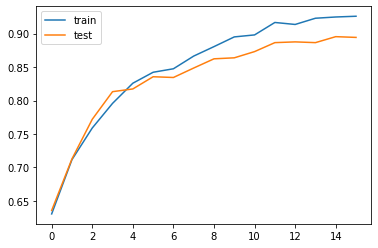

epoch 16/50, 918s since start
tensor(0.2393, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1452, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2410, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9174 test_accuracy 0.8940


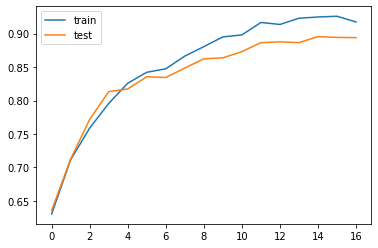

epoch 17/50, 975s since start
tensor(0.1500, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2085, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9368 test_accuracy 0.8836


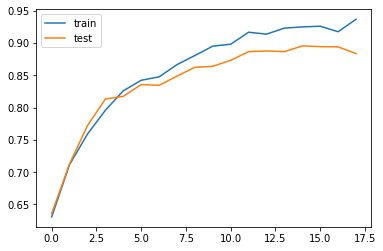

epoch 18/50, 1033s since start
tensor(0.2803, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1156, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1109, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9397 test_accuracy 0.8917


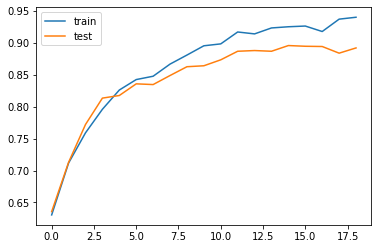

epoch 19/50, 1090s since start
tensor(0.1637, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1515, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1607, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9554 test_accuracy 0.9018


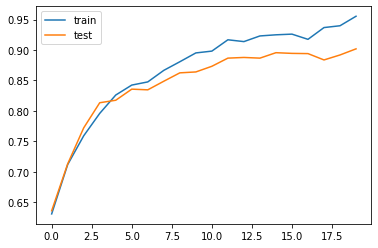

epoch 20/50, 1148s since start
tensor(0.1515, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0942, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1472, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9442 test_accuracy 0.8936


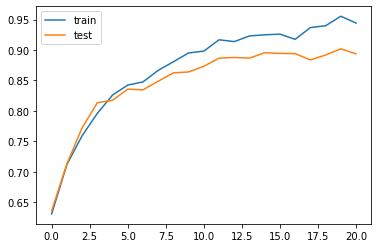

epoch 21/50, 1205s since start
tensor(0.1147, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1002, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9602 test_accuracy 0.9070


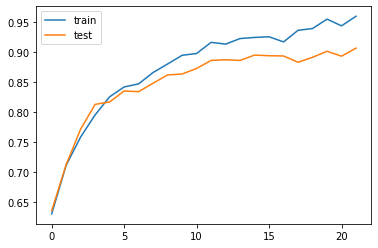

epoch 22/50, 1262s since start
tensor(0.1141, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2585, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1159, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9487 test_accuracy 0.9055


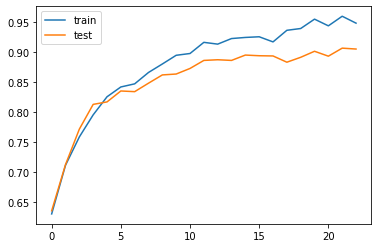

epoch 23/50, 1320s since start
tensor(0.1255, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1126, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0856, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9554 test_accuracy 0.8940


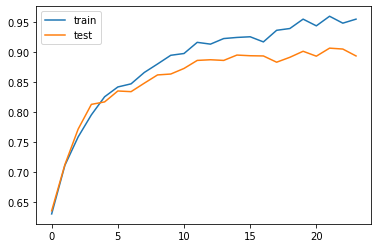

epoch 24/50, 1377s since start
tensor(0.1332, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1014, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9561 test_accuracy 0.9129


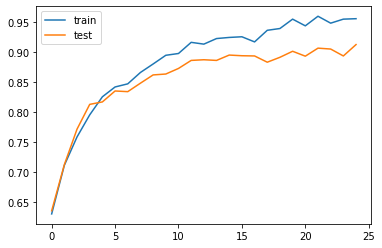

epoch 25/50, 1435s since start
tensor(0.1646, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0654, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1315, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9561 test_accuracy 0.9014


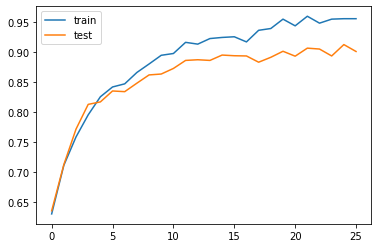

epoch 26/50, 1492s since start
tensor(0.1768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1473, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0669, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9602 test_accuracy 0.9096


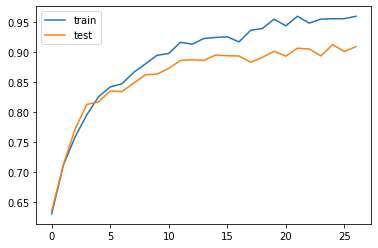

epoch 27/50, 1549s since start
tensor(0.1788, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1960, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9628 test_accuracy 0.8999


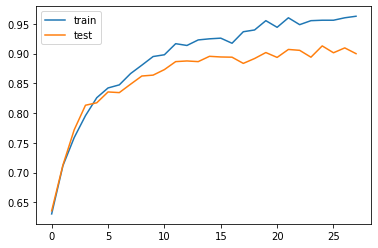

epoch 28/50, 1607s since start
tensor(0.0788, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2085, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9639 test_accuracy 0.9070


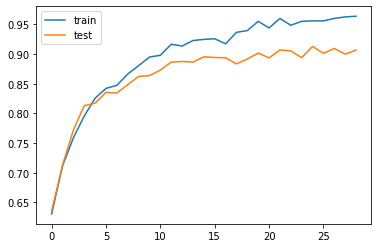

epoch 29/50, 1664s since start
tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0810, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9754 test_accuracy 0.9144


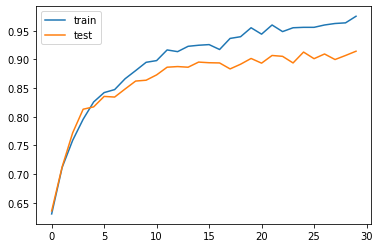

epoch 30/50, 1721s since start
tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1397, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9714 test_accuracy 0.9111


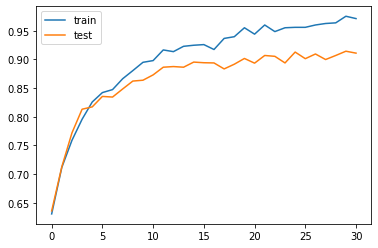

epoch 31/50, 1779s since start
tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9699 test_accuracy 0.9096


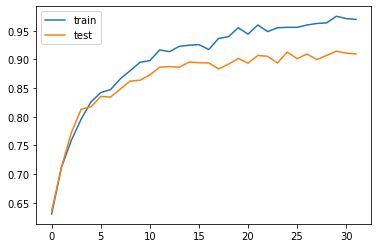

epoch 32/50, 1836s since start
tensor(0.1108, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1112, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0741, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9740 test_accuracy 0.9092


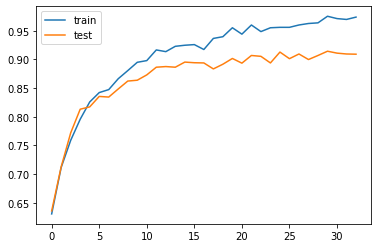

epoch 33/50, 1894s since start
tensor(0.0303, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0540, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9777 test_accuracy 0.9200


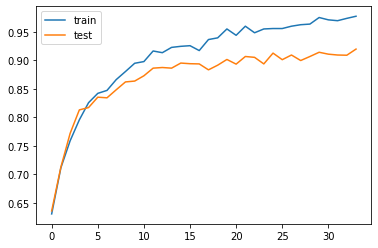

epoch 34/50, 1951s since start
tensor(0.0638, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0624, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9777 test_accuracy 0.9211


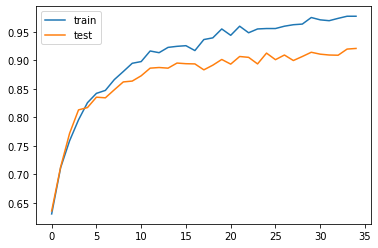

epoch 35/50, 2008s since start
tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0336, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9777 test_accuracy 0.9129


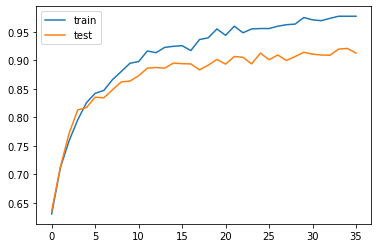

epoch 36/50, 2066s since start
tensor(0.1095, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0559, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9743 test_accuracy 0.9048


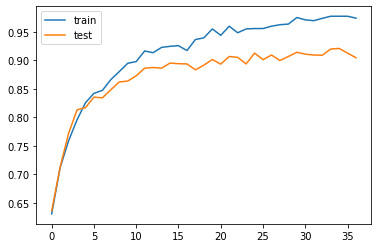

epoch 37/50, 2123s since start
tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9799 test_accuracy 0.9059


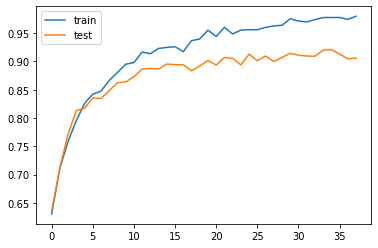

epoch 38/50, 2180s since start
tensor(0.0517, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0594, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9825 test_accuracy 0.9163


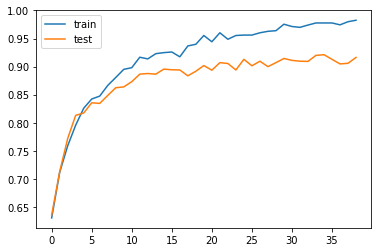

epoch 39/50, 2237s since start
tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9825 test_accuracy 0.9070


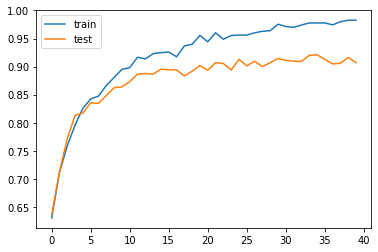

epoch 40/50, 2295s since start
tensor(0.0752, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9751 test_accuracy 0.9167


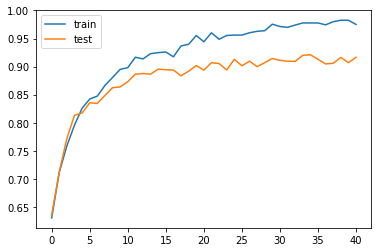

epoch 41/50, 2352s since start
tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0466, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9814 test_accuracy 0.9048


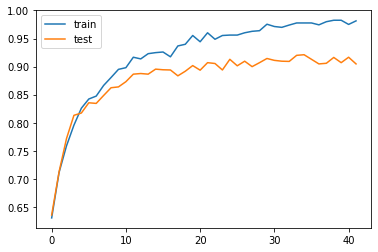

epoch 42/50, 2410s since start
tensor(0.0327, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9833 test_accuracy 0.9167


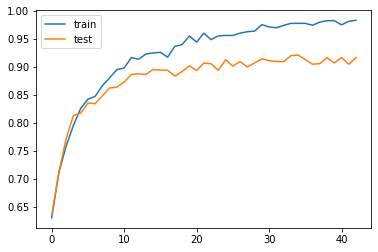

epoch 43/50, 2467s since start
tensor(0.0218, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9851 test_accuracy 0.9178


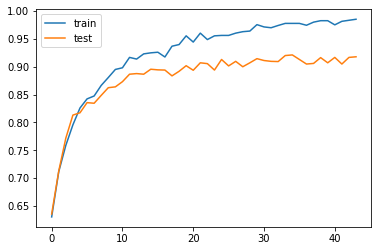

epoch 44/50, 2525s since start
tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9866 test_accuracy 0.9081


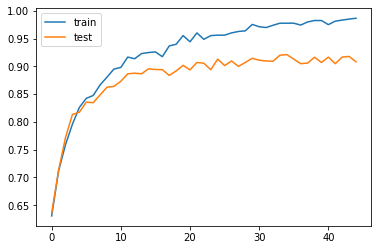

epoch 45/50, 2582s since start
tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0333, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9844 test_accuracy 0.9182


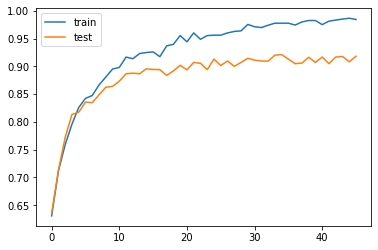

epoch 46/50, 2640s since start
tensor(0.0500, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9859 test_accuracy 0.9159


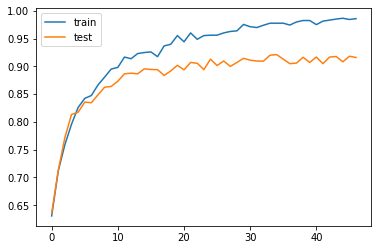

epoch 47/50, 2697s since start
tensor(0.0330, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0274, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9888 test_accuracy 0.9182


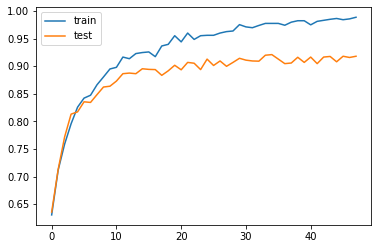

epoch 48/50, 2754s since start
tensor(0.0298, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0482, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0618, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9851 test_accuracy 0.9129


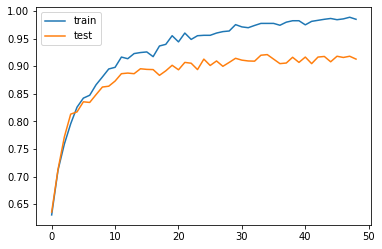

epoch 49/50, 2811s since start
tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0277, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward>)
train_accuracy 0.9888 test_accuracy 0.9122


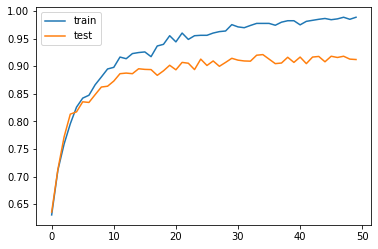

In [8]:
import time

n_epochs = 50

start_time = time.time()

optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

train_accuracies = []
test_accuracies  = []

for epoch in range(n_epochs):
  print(f"epoch {epoch}/{n_epochs}, {time.time() - start_time:.0f}s since start")
  
  criterion = nn.CrossEntropyLoss()
  
  def get_accuracy(dataloader):
    with torch.no_grad():
      cur_accuracies = []
      for batch_id, (X, y) in enumerate(dataloader):
        if batch_id > 20:
          break
        X, y = X.to(device), y.to(device)

        output = model.forward(X)
        y_pred = output.argmax(dim=1)
        cur_accuracies.append((y == y_pred).double().mean().item())
    return np.average(cur_accuracies)

  for batch_id, (X, y) in enumerate(train_loader):
    optimizer.zero_grad()
    X, y = X.to(device), y.to(device)

    output = model.forward(X)
    
    loss = criterion(output, y)
    if batch_id < 3:
      print(loss)

    loss.backward()
    optimizer.step()

  train_accuracy = get_accuracy(train_loader)
  test_accuracy  = get_accuracy(test_loader)

  print(f"train_accuracy {train_accuracy:.4f} test_accuracy {test_accuracy:.4f}")
  
  train_accuracies.append(train_accuracy)
  test_accuracies.append( test_accuracy)

  l = len(test_accuracies)
  plt.plot(np.arange(l), train_accuracies, label='train')
  plt.plot(np.arange(l), test_accuracies, label='test')
  plt.legend()
  plt.show()